## CrossRef evaluation

In [1]:
### All Imports
import ast
import json
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
## Loading the file which contains the 10000 random citations
selected_citations = pd.read_csv('selected_citations_for_evaluation_10000.csv')

In [3]:
## Reading the file which contains 10000 citations which are random in nature
selected_citations.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
selected_citations.head()

,authors_list,citation_title,citation,page_title,id_list,DOI
0,"['Friedrich B', 'Feng Y', 'Cohen P', 'Risler T...",The serine/threonine kinases SGK2 and SGK3 are...,Map(Title -> The serine/threonine kinases SGK2...,SGK2,"[['PMID', '12632189'], ['DOI', '10.1007/s00424...",10.1007/s00424-002-0993-8
1,"['Scherer Stephen', 'Cheung J', 'MacDonald JR'...",Human Chromosome 7: DNA Sequence and Biology,Map(Title -> Human Chromosome 7: DNA Sequence ...,Ectrodactyly,"[['PMID', '12690205'], ['PMC', '2882961'], ['D...",10.1126/science.1083423
2,"['Kuiper GG', 'Carlsson B', 'Grandien K', 'Enm...",Comparison of the ligand binding specificity a...,Map(Title -> Comparison of the ligand binding ...,Androstenedione,"[['PMID', '9048584'], ['DOI', '10.1210/endo.13...",10.1210/endo.138.3.4979
3,['Makepeace Tsao'],A New Synthesis of Mescaline,"Map(Title -> A New Synthesis of Mescaline, Vol...",Mescaline,"[['DOI', '10.1021/ja01155a562']]",10.1021/ja01155a562
4,['Rennie David'],Two Thoughts on Abraham Maslow.,"Map(Title -> Two Thoughts on Abraham Maslow., ...",Abraham Maslow,"[['DOI', '10.1177/0022167808320537']]",10.1177/0022167808320537


In [4]:
print(
    'Number of total citations: {} and number with unique title: {}'.format(
        selected_citations.shape[0], selected_citations['citation_title'].nunique())
)

Number of total citations: 10000 and number with unique title: 9707


In [5]:
## Getting the author and title for each of the unique random citations we have
def get_params(dataset):
    params = []
    for i in range(dataset.shape[0]):
        r_dict = dict()
        title_ = dataset.iloc[i]['citation_title']
        r_dict['query.bibliographic'] = title_
        author = ast.literal_eval(dataset.iloc[i]['authors_list'])[0]
        if author != 'No authors':
            r_dict['query.author'] = author
            r_dict['DOI'] = dataset.iloc[i]['DOI']
            params.append(r_dict)

    print('Constructed parameters for requests')
    return params

In [6]:
params = get_params(selected_citations)
print('Total number of unique params: {}'.format(len(params)))

Constructed parameters for requests
Total number of unique params: 9764


In [7]:
## Get all the indices and shuffle them 
indices = np.arange(len(params))
np.random.shuffle(indices)

In [8]:
## Make a train and test split for checking which heuristic is the best heuristic
SPLIT_THRESHOLD = (len(params) * 80) // 100
 
training_indices = indices[:SPLIT_THRESHOLD]
testing_indices = indices[SPLIT_THRESHOLD:]

training_content = [j for i, j in enumerate(params) if i in training_indices]
training_dois = [i['DOI'] for i in training_content]
testing_content  = [j for i, j in enumerate(params) if i in testing_indices]
testing_dois = [i['DOI'] for i in testing_content]

In [9]:
## taking in the column of score as the threshold and putting title, author, and DOI in dataframe
def get_eval(score_number, training=True):
    
    indices__, dois__, content = None, None, None
    if training:
        indices__, dois__, content = training_indices, training_dois, training_content
    else:
        indices__, dois__, content = testing_indices, testing_dois, testing_content
        
    crossref_invalid = 0 ## Requests which are not present in CrossRef for some reason
    no_result_for_heuristic = 0
    
    info_threshold = []
    for i in tqdm_notebook(range(len(indices__))):
    
        with open('lookup_eval/result_{}.txt'.format(indices__[i])) as f:
            file_content = json.loads(f.read())
        
        if 'items' not in file_content['message'] or len(file_content['message']['items']) == 0:
            crossref_invalid += 1
            continue

        if len(file_content['message']['items']) <= score_number:
            no_result_for_heuristic += 1
            continue
            
        res = file_content['message']['items'][score_number] ## score_number represents the threshold
        res_doi = res.get('DOI', 'No DOI')
        res_title = res.get('title', ['No title'])[0]
        res_score = res.get('score', 'No score')
        info_threshold.append([res_doi, res_title, res_score])

    take_score = pd.DataFrame(info_threshold)
    take_score.rename({0: 'ID', 1: 'title', 2: 'score'}, axis=1, inplace=True)

    present = []
    not_present = []
    for i, j, l in zip(list(take_score['ID']), list(take_score['score']), list(take_score['title'])):
        if i in dois__:
            present_res = [k for k in content if k['DOI'] == i]
            present.append([i, j, l, present_res])
        else:
            not_present.append([i, j, l])
    print('Total number of retreieved IDs present in original: {}'.format(len(present)))
    print('Total number of retreieved IDs NOT present in original: {}'.format(len(not_present)))
    print('Total number of IDs for which CrossRef request is not valid: {}'.format(crossref_invalid))
    print('Total number of IDs for which there is no result for that heuristic: {}'.format(no_result_for_heuristic))
    return present, not_present

In [10]:
present_first_score, not_present_first_score = get_eval(0)


Total number of retreieved IDs present in original: 5281
Total number of retreieved IDs NOT present in original: 2492
Total number of IDs for which CrossRef request is not valid: 38
Total number of IDs for which there is no result for that heuristic: 0


In [11]:
present_second_score, not_present_second_score = get_eval(1)


Total number of retreieved IDs present in original: 344
Total number of retreieved IDs NOT present in original: 7415
Total number of IDs for which CrossRef request is not valid: 38
Total number of IDs for which there is no result for that heuristic: 14


In [12]:
present_third_score, not_present_third_score = get_eval(2)


Total number of retreieved IDs present in original: 109
Total number of retreieved IDs NOT present in original: 7639
Total number of IDs for which CrossRef request is not valid: 38
Total number of IDs for which there is no result for that heuristic: 25


In [13]:
print('Is 2nd threshold any better: {}'.format(
    any([True if i in not_present_first_score else False for i in present_second_score])))
print('Is 3rd threshold any better: {}'.format(
    any([True if i in not_present_first_score else False for i in present_third_score])))

Is 2nd threshold any better: False
Is 3rd threshold any better: False


From the part above, we see that the best heuristic is given by the item which has the highest score or the one which is first in the list by index. Now, we check it on the testing set..

### Testing part just check the best threshold gained in the first part

In [14]:
print('Total points in the testing set: {}'.format(len(testing_indices)))

Total points in the testing set: 1953


In [15]:
## Passing 0 as the parameter as we know the first is the best heuristic
presenting_testing_score, not_present_testing_score = get_eval(0, training=False)


Total number of retreieved IDs present in original: 1297
Total number of retreieved IDs NOT present in original: 646
Total number of IDs for which CrossRef request is not valid: 10
Total number of IDs for which there is no result for that heuristic: 0


In [16]:
presenting_testing_score[229], presenting_testing_score[17]

(['10.2307/1380498',
  99.06795,
  'Ecology of the Key Largo Woodrat (Neotoma floridana smalli)',
  [{'query.bibliographic': 'Ecology of the Key Largo woodrat (Neotoma floridana smalli)',
    'query.author': 'Hersh S.L.',
    'DOI': '10.2307/1380498'}]],
 ['10.1017/s0026749x01002037',
  133.62733,
  'Courting Legitimacy or Delegitimizing Custom? Sexuality, Sambandham, and Marriage Reform in Late Nineteenth-Century Malabar',
  [{'query.bibliographic': 'Courting Legitimacy or Delegitimizing Custom? Sexuality, Sambandham and Marriage Reform in Late Nineteenth-Century Malabar',
    'query.author': 'Kodoth Praveena',
    'DOI': '10.1017/s0026749x01002037'}]])

1. x-axis: confidence scores (please let me know the range, pick 100 uniform intervals)
2. y-axis: relative precision and recall (2 lines, use different colours and add a legend). By relative P and R I mean:
    1. Relative precision: number of correctly matched DOIs using the given threshold divided by the total number of matches above the threshold (takes values between 0 and 1, it should go up as the threshold goes up). So, for example, if you use a dataset of 100 citations, you look them all up, you use a threshold of 0.5 and have 60 matches above this threshold, and of these 60 you have 50 that are correct, your precision is 50/60 = 0.83
    2. Relative recall: number of correctly matched DOIs using the given threshold divided by the total number of matches above the threshold (takes values between 0 and 1, it should go down as the threshold goes up). So, for example, if you use a dataset of 100 citations, you look them all up, you use a threshold of 0.5 and have 60 matches above this threshold, and of these 60 you have 50 that are correct, your recall is 50/100 = 0.5

In [17]:
all_scores = [i[1] for i in present_first_score] + [i[1] for i in not_present_first_score]

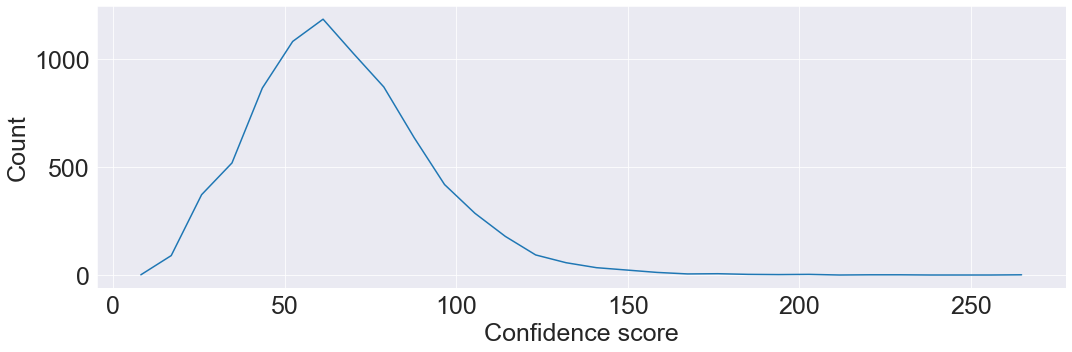

In [128]:
## Print the histogram for the confidence scores with bins and set
y, binEdges = np.histogram(all_scores, bins=30)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
params = {
    'figure.figsize': (15, 5), 'axes.labelsize': '25', 
    'axes.titlesize': '25', 'xtick.labelsize': '25', 'ytick.labelsize': '25'
}
p.rcParams.update(params)

p.plot(bincenters, y, '-')
p.xlabel('Confidence score')
p.ylabel('Count')
p.tight_layout()
p.show()

In [20]:
all_data = [i for i in present_first_score] + [i for i in not_present_first_score]

In [21]:
## Get the equivalent intervals between the max and minimum confidence scores
start = min(all_scores)
end = max(all_scores)
intervals = np.linspace(0, end, 30)

In [121]:
print('Total number of unique training split points: {}'.format(len(all_data)))

Total number of unique training split points: 7773


In [23]:
all_dois = [i[0] for i in all_data]

In [24]:
graph_result = []
for ind in range(len(intervals) - 1):
    subset_interval = [
        i for i in all_data
        if i[1] >= intervals[ind]
    ]
    subset_len_four = sum([1 for i in subset_interval if len(i) == 4])
    if subset_len_four == 0:
        graph_result.append([intervals[ind], intervals[ind + 1], len(subset_interval), 0, 0])
    else:
        precision = subset_len_four / len(subset_interval)
        recall = subset_len_four / len(all_data)
        graph_result.append([intervals[ind], intervals[ind + 1], len(subset_interval), precision, recall])

In [120]:
print(intervals)
print('\nTotal number of intervals are: {}'.format(len(graph_result)))

[  0.           9.28161621  18.56323241  27.84484862  37.12646483
  46.40808103  55.68969724  64.97131345  74.25292966  83.53454586
  92.81616207 102.09777828 111.37939448 120.66101069 129.9426269
 139.2242431  148.50585931 157.78747552 167.06909172 176.35070793
 185.63232414 194.91394034 204.19555655 213.47717276 222.75878897
 232.04040517 241.32202138 250.60363759 259.88525379 269.16687   ]

Total number of intervals are: 29


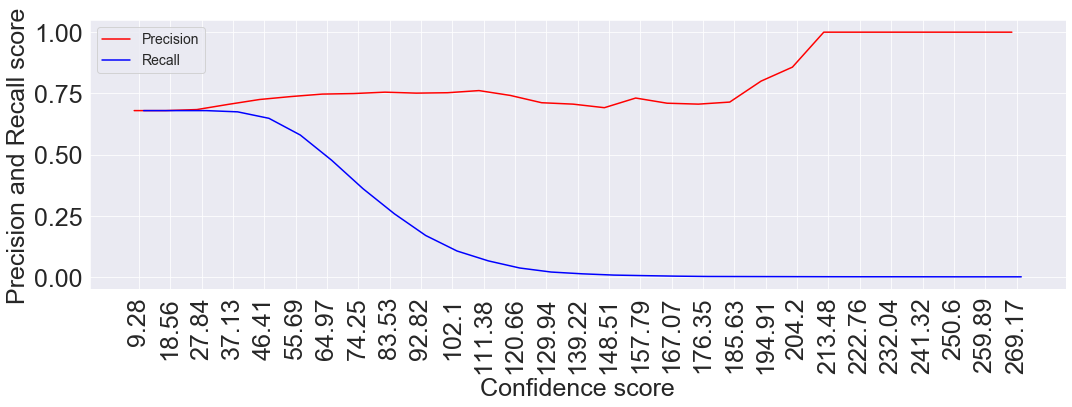

In [131]:
N = len(graph_result)
n_precision = [i[3] for i in graph_result]

ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

rects1 = ax.plot(ind, n_precision, width, color='r')

n_recall = [i[4] for i in graph_result]
rects2 = ax.plot(ind + width, n_recall, width, color='b')

# add some text for labels, title and axes ticks
ax.set_xlabel('Confidence score')
ax.set_ylabel('Precision and Recall score')
ax.set_xticks(ind + width / 2)

plt.tight_layout()

ax.legend((rects1[0], rects2[0]), ('Precision', 'Recall'), prop={'size': 14})

n_xticklabels = [round(i[1], 2) for i in graph_result]
ax.set_xticklabels(n_xticklabels, rotation='vertical')

interval_info = [i[2] for i in graph_result]

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(25)

plt.show()

In [116]:
print('At threshold: 34.997, the precision is: {}'.format(np.interp(34.997, n_xticklabels, n_precision)))
print('At threshold: 34.997, the recall is: {}'.format(np.interp(34.997, n_xticklabels, n_recall)))

At threshold: 34.997, the precision is: 0.7000000964922501
At threshold: 34.997, the recall is: 0.6755376903600925


In [124]:
## Out of 1297, 1246 points are greater than the threshold
print('Number of data points less than the threshold: {}'.format(sum([1 for i in presenting_testing_score if i[1] < 34.997])))

Number of data points less than the threshold: 51


In [125]:
## Out of 646, 521 points are greater than the threshold
print('Number of data points less than the threshold: {}'.format(sum([1 for i in not_present_testing_score if i[1] < 34.997])))

Number of data points less than the threshold: 125


In [118]:
print('The range of min: {} and max: {} confidence scores'.format(min(all_scores), max(all_scores)))

The range of min: 3.658947 and max: 269.16687 confidence scores
